##Setting Up the Requirements




In [0]:
!nvidia-smi

Tue Jul  9 06:08:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:

!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 28220 (delta 5), reused 7 (delta 2), pack-reused 28198
Receiving objects: 100% (28220/28220), 509.36 MiB | 38.98 MiB/s, done.
Resolving deltas: 100% (17375/17375), done.
Checking out files: 100% (3004/3004), done.


In [0]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk


Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.16-2~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 4 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,688 kB of additional disk space will be used.
Get:1 http

In [0]:
!pip install -q Cython contextlib2 pillow lxml # matplotlib PyDrive

In [0]:
!pip install pycocotools # NOT REQUIRED

In [0]:
%cd models/research/

/content/models/research


In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'


In [0]:
!python3 object_detection/builders/model_builder_test.py

W0709 06:09:16.945338 139913982637952 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0709 06:09:17.259598 139913982637952 deprecation_wrapper.py:119] From /content/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0709 06:09:17.308539 139913982637952 deprecation_wrapper.py:119] From /content/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

Running tests under Python 3.6.8: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK

## Connecting with Drive and copying the Data

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!apt-get install -qq protobuf-compiler python-tk

In [0]:
!python3 setup.py install

 Now we move our directory from **"content/drive/My\  Drive/ObjectDetection"**  to **""/content/models/research/ObjectDetection"** 






In [0]:
!ls

drive  models  sample_data


In [0]:
!scp -r /content/drive/My\ Drive/ObjectDetection/* /content/models/research/object_detection/


In [0]:
%cd ./ObjectDetection/

/content/models/research/ObjectDetection


## Generating TF-Records

In [0]:
%%writefile generate_tfrecord.py
"""
Usage:
  # From tensorflow/models/
  # Create train data:
  python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=train.record
  # Create test data:
  python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=test.record
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
flags.DEFINE_string('image_dir', '', 'Path to images')
FLAGS = flags.FLAGS


# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'macncheese':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(FLAGS.image_dir)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


if __name__ == '__main__':
  tf.app.run()

Writing generate_tfrecord.py


In [0]:
!ls

data  generate_tfrecord.py  images  xml_to_csv.py


In [0]:
!python3 generate_tfrecord.py --csv_input=data/train_labels.csv --output_path=data/train.record --image_dir=images/train


W0709 06:18:10.057260 140676884174720 deprecation_wrapper.py:119] From generate_tfrecord.py:99: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0709 06:18:10.057878 140676884174720 deprecation_wrapper.py:119] From generate_tfrecord.py:85: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0709 06:18:10.120278 140676884174720 deprecation_wrapper.py:119] From generate_tfrecord.py:44: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/models/research/ObjectDetection/data/train.record


In [0]:
!python3 generate_tfrecord.py --csv_input=data/test_labels.csv --output_path=data/test.record --image_dir=images/test

W0709 06:18:14.768598 139702060611456 deprecation_wrapper.py:119] From generate_tfrecord.py:99: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0709 06:18:14.769160 139702060611456 deprecation_wrapper.py:119] From generate_tfrecord.py:85: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0709 06:18:14.783669 139702060611456 deprecation_wrapper.py:119] From generate_tfrecord.py:44: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/models/research/ObjectDetection/data/test.record


## Downloading & Setting up Model and config file

In [0]:
!wget download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz

--2019-07-09 06:18:23--  http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.198.128, 2607:f8b0:4001:c12::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.198.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51025348 (49M) [application/x-tar]
Saving to: ‘ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz’

ssdlite_mobilenet_v 100%[===================>]  48.66M  94.8MB/s    in 0.5s    

2019-07-09 06:18:24 (94.8 MB/s) - ‘ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz’ saved [51025348/51025348]



In [0]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/samples/configs/ssdlite_mobilenet_v2_coco.config

--2019-07-09 06:18:32--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/samples/configs/ssdlite_mobilenet_v2_coco.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4778 (4.7K) [text/plain]
Saving to: ‘ssdlite_mobilenet_v2_coco.config’

ssdlite_mobilenet_v 100%[===================>]   4.67K  --.-KB/s    in 0s      

2019-07-09 06:18:32 (31.9 MB/s) - ‘ssdlite_mobilenet_v2_coco.config’ saved [4778/4778]



In [0]:
!tar -xzvf  ../object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz  -C ../object_detection/

ssdlite_mobilenet_v2_coco_2018_05_09/checkpoint
ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt.data-00000-of-00001
ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt.meta
ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt.index
ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/saved_model.pb
ssdlite_mobilenet_v2_coco_2018_05_09/pipeline.config
ssdlite_mobilenet_v2_coco_2018_05_09/frozen_inference_graph.pb
ssdlite_mobilenet_v2_coco_2018_05_09/
ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/variables/
ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/


In [0]:
!cat ssdlite_mobilenet_v2_coco.config

In [0]:
%%writefile ssdlite_mobilenet_v2_coco.config

# SSDLite with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.8
        kernel_size: 3
        use_depthwise: true
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      use_depthwise: true
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 128
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.004
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "object_detection/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "ObjectDetection/data/train.record"
  }
  label_map_path: "ObjectDetection/ObjectDetection.pbtxt"
}

eval_config: {
  num_examples: 8000
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "ObjectDetection/data/test.record"
  }
  label_map_path: "ObjectDetection/ObjectDetection.pbtxt"
  shuffle: false
  num_readers: 1
}



Writing ssdlite_mobilenet_v2_coco.config


## Training

In [0]:
%%writefile ObjectDetection.pbtxt
item {
  id: 1
  name: 'macncheese'
}

Writing ObjectDetection.pbtxt


In [0]:
%cd ../

/content/models/research


In [0]:
!python3 object_detection/legacy/train.py --logtostderr --train_dir=ObjectDetection/ --pipeline_config_path=ObjectDetection/ssdlite_mobilenet_v2_coco.config

I0709 11:09:08.212782 140206116345728 learning.py:507] global step 13205: loss = 0.6455 (0.997 sec/step)
I0709 11:09:09.227390 140206116345728 learning.py:507] global step 13206: loss = 0.8680 (1.013 sec/step)
I0709 11:09:10.620197 140206116345728 learning.py:507] global step 13207: loss = 0.4999 (1.391 sec/step)
I0709 11:09:11.612828 140206116345728 learning.py:507] global step 13208: loss = 0.5358 (0.991 sec/step)
I0709 11:09:12.587683 140206116345728 learning.py:507] global step 13209: loss = 0.5883 (0.973 sec/step)
I0709 11:09:13.580549 140206116345728 learning.py:507] global step 13210: loss = 0.8056 (0.991 sec/step)
I0709 11:09:14.534784 140206116345728 learning.py:507] global step 13211: loss = 0.6535 (0.953 sec/step)
I0709 11:09:15.488341 140206116345728 learning.py:507] global step 13212: loss = 0.6668 (0.952 sec/step)
I0709 11:09:16.457064 140206116345728 learning.py:507] global step 13213: loss = 0.7372 (0.967 sec/step)
I0709 11:09:17.476153 140206116345728 learning.py:507] 

##Inference

The inference graph checkpoints created by model   **model.ckpt-12345(.data-00000-of-00001) or (.index) or (.meta)** but we need to write only till the number part not the extension 



In [0]:
!python3 object_detection/export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path object_detection/ssdlite_mobilenet_v2_coco.config \
    --trained_checkpoint_prefix ObjectDetection/model.ckpt-13081 \
    --output_directory mac_n_cheese_inference_graph

In [0]:
MODEL_NAME = 'mac_n_cheese_inference_graph/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('ObjectDetection/', 'ObjectDetection.pbtxt')

In [0]:
import tensorflow as tf
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
%cd ../

/content/models/research


In [0]:
from utils import label_map_util
from PIL import Image

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

W0709 14:28:18.058471 140517437757312 deprecation_wrapper.py:119] From /content/models/research/object_detection/utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
PATH_TO_TEST_IMAGES_DIR = 'test_images/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}'.format(i)) for i in os.listdir(PATH_TO_TEST_IMAGES_DIR) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 12)

In [0]:
TEST_IMAGE_PATHS

['test_images/Tortellini-en-brodo-1002x668.jpg',
 'test_images/healthy-mac-and-cheese-51.jpg']

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

### Downloading test images

In [0]:
!mkdir test_images

In [0]:
%cd test_images/

/content/models/research/test_images


In [0]:
!wget https://www.contentednesscooking.com/wp-content/uploads/2018/02/Cauliflower-Mac-Cheese-4-533x800.jpg

--2019-07-09 14:56:04--  https://www.contentednesscooking.com/wp-content/uploads/2018/02/Cauliflower-Mac-Cheese-4-533x800.jpg
Resolving www.contentednesscooking.com (www.contentednesscooking.com)... 107.161.181.186
Connecting to www.contentednesscooking.com (www.contentednesscooking.com)|107.161.181.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59222 (58K) [image/jpeg]
Saving to: ‘Cauliflower-Mac-Cheese-4-533x800.jpg’

Cauliflower-Mac-Che 100%[===================>]  57.83K  --.-KB/s    in 0.1s    

2019-07-09 14:56:04 (598 KB/s) - ‘Cauliflower-Mac-Cheese-4-533x800.jpg’ saved [59222/59222]



###Testing them

In [0]:
%cd ../

/content/models/research


In [0]:
import numpy as np
from utils import visualization_utils as vis_util
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

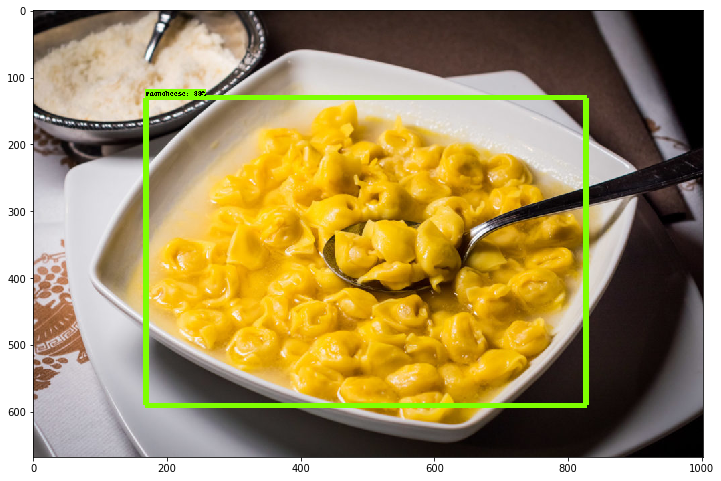

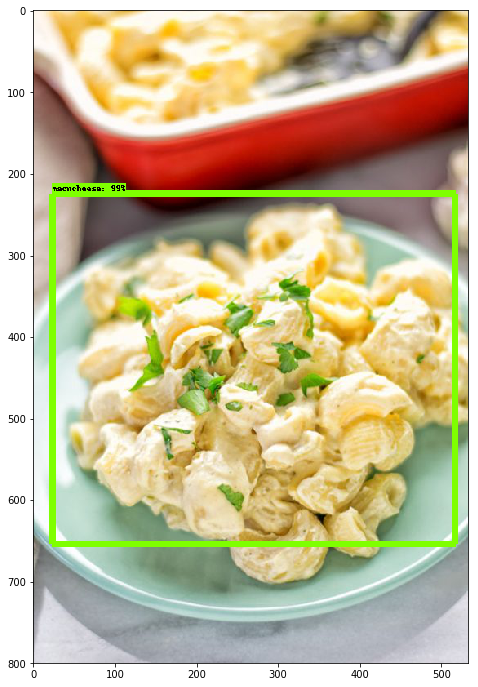

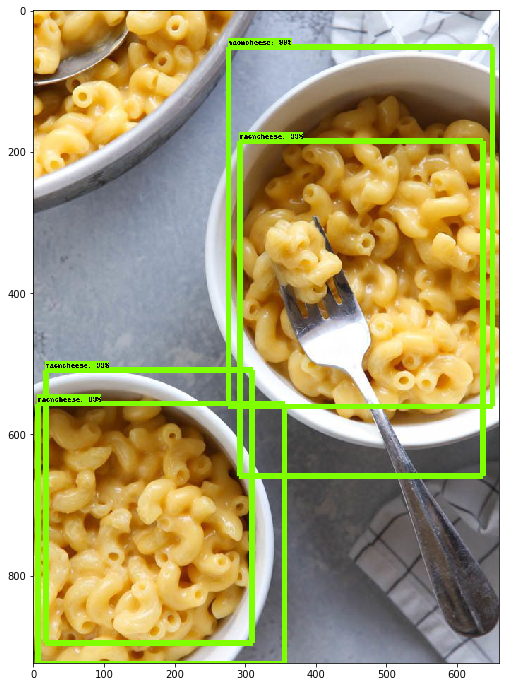

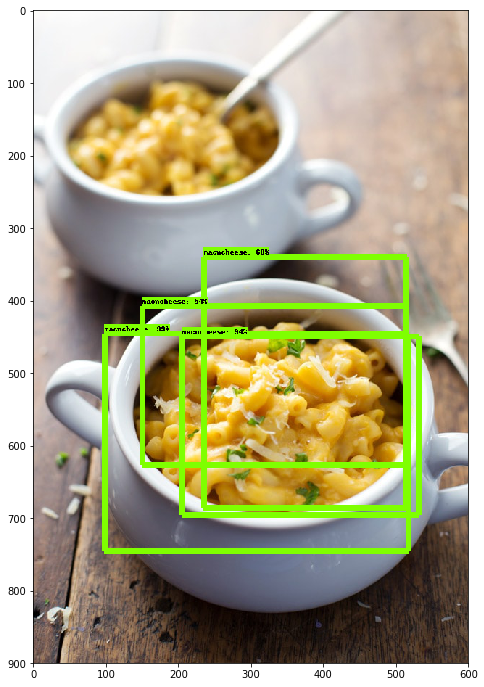

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)